In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

In [3]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (15, 15)

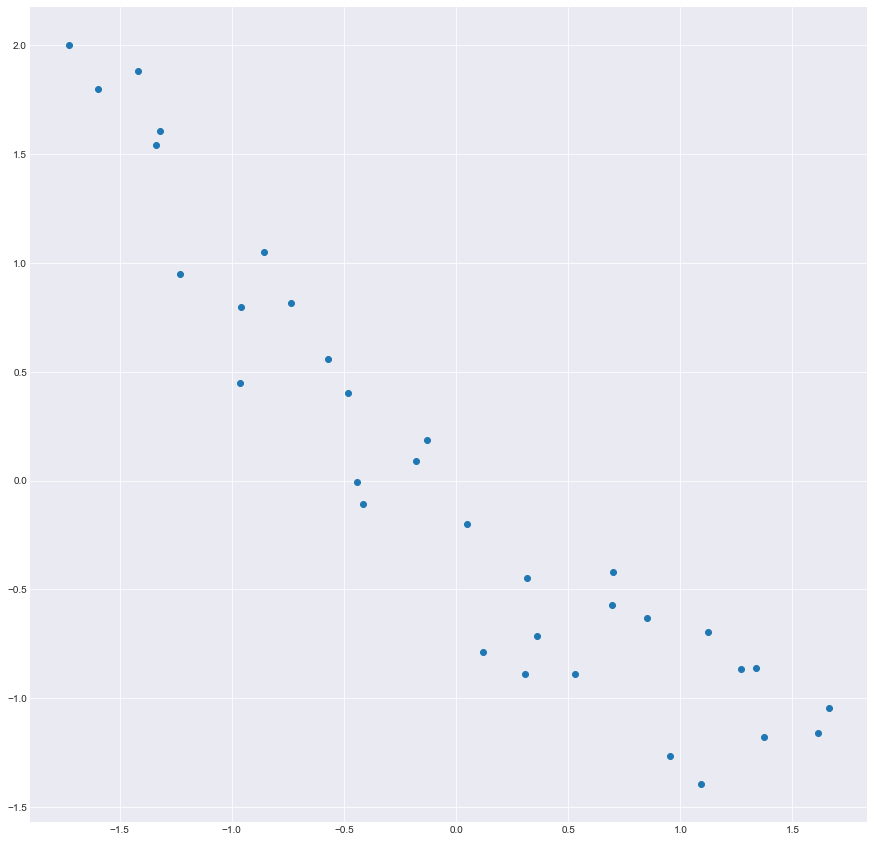

In [4]:
def standardize(xs):
    if len(xs.shape) == 1:
        return (xs - xs.mean()) / xs.std()
    return (xs - xs.mean(axis=1, keepdims=True)) / xs.std(axis=1, keepdims=True)

points = np.loadtxt('../data/dummy.csv')
xs = standardize(points[:, 0])
ys = standardize(points[:, 1])
plt.scatter(xs, ys);

In [5]:
def monomials(xs, order):
    return np.vstack([xs**d for d in range(0, order + 1)]) 

def sample(xs, ys, order):
    xss = monomials(xs, order)
    with pm.Model() as model:
        β = pm.Normal('β', mu=0, sd=10, shape=order + 1)
        ε = pm.HalfNormal('ε', 5)
        μ = pm.math.dot(β, xss)
        y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=ys)
        return (pm.sample(2000), model)

In [6]:
(traces, models) = list(zip(*[sample(xs, ys, order=d) for d in range(1, 6)]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1640.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1244.48draws/s]
The acceptance probability does not match the target. It is 0.8912723702491467, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 901.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:09<00:00, 507.26draws/s]
The acceptance pro

In [7]:
def plot_curve(trace, bounds, steps=100):
    (lo, hi) = bounds
    (_, count) = trace['β'].shape
    xs = np.linspace(lo, hi, steps)
    xss = monomials(xs, count - 1)
    β = trace['β'].mean(axis=0)
    ys = np.dot(β, xss)
    plt.plot(xs, ys, label=f'degree {count - 1}')    
    
def plot_all_curves(traces, bounds, steps=100):
    bounds = (xs.min(), xs.max())
    for trace in traces:
        plot_curve(trace, bounds)
        plt.legend()

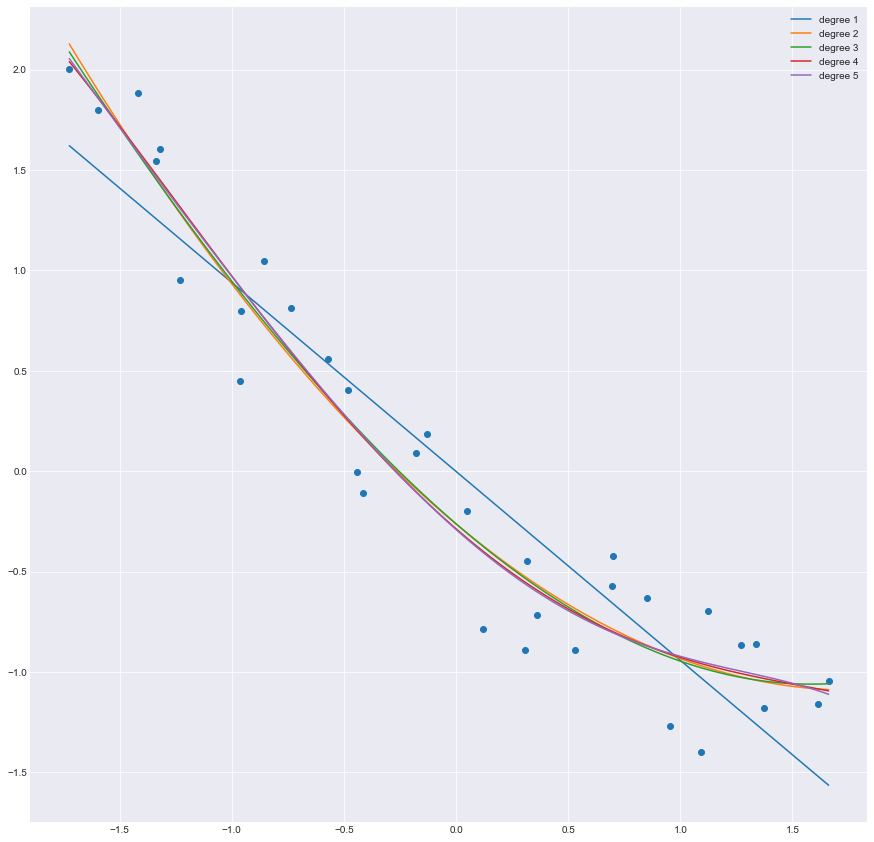

In [8]:
plt.scatter(xs, ys)
plot_all_curves(traces, (xs.min(), xs.max()))

In [9]:
pp_samples = [pm.sample_posterior_predictive(trace, 2000, model=model)['y_pred']
              for (trace, model) in zip(traces, models)]

100%|██████████| 2000/2000 [00:01<00:00, 1584.25it/s]


In [10]:
def iqr(xs, axis=0):
    return np.subtract(*np.percentile(xs, [75, 25], axis=axis))

def plot_stats(ys, pp_samples, statistics=None):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
    statistics = statistics or [np.mean, iqr]
    for (i, fn) in enumerate(statistics):
        t_ys = fn(ys)
        ax[i].axvline(t_ys, 0, 1, color='k', ls='--')
        for (j, pp) in enumerate(pp_samples):
            t_pp = fn(pp, axis=1)
            p_value = np.mean(t_pp >= t_ys)
            az.plot_kde(
                t_pp,
                plot_kwargs={'color': f'C{j + 1}'},
                label=f'p-value {p_value:.2f}, degree {j + 1}',
                ax=ax[i])

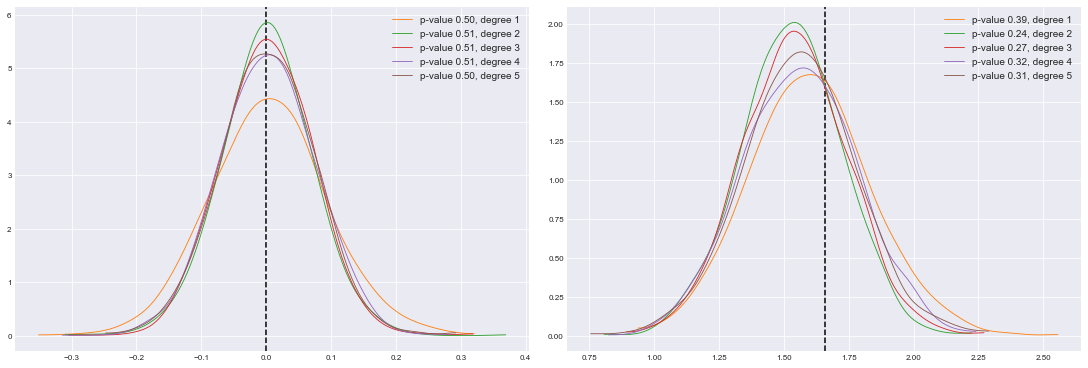

In [130]:
plot_stats(ys, pp_samples)

#### The widely applicable information criterion
It was introduced in a seemingly interesting and readable paper in 2011 (link http://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf).

In [11]:
waics = [az.waic(trace) for trace in traces]

/home/bart/.pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


In [12]:
comparison = az.compare(dict(zip([f'degree {i + 1}' for i in range(len(traces))], traces)), method='BB-pseudo-BMA')
display(comparison)

/home/bart/.pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
degree 2,8.9507,2.58182,0,0.664029,4.43796,0,0,deviance
degree 3,11.2332,3.40622,2.28245,0.213231,4.71665,0.640449,0,deviance
degree 4,13.1807,4.22434,4.22997,0.0875861,4.52615,1.23046,1,deviance
degree 5,15.1143,4.77637,6.16358,0.034676,5.32473,1.37327,1,deviance
degree 1,28.86,2.49243,19.9093,0.000478166,4.5305,5.34386,0,deviance


In [13]:
pp_averaged = pm.sample_posterior_predictive_w(traces, samples=1000, models=models, weights=comparison.weight)

100%|██████████| 1000/1000 [00:00<00:00, 1584.24it/s]


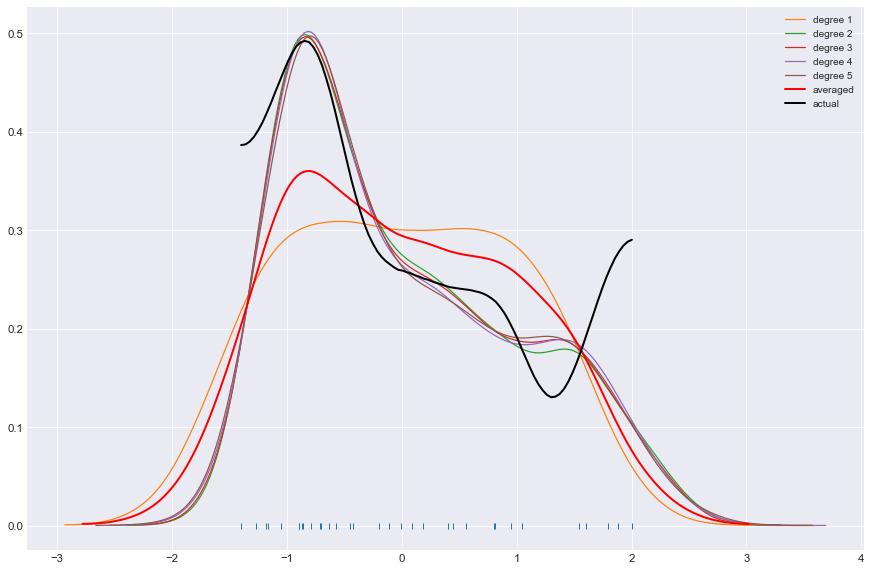

In [21]:
_, ax = plt.subplots(figsize=(15, 10))
for (i, pp) in enumerate(pp_samples):
    az.plot_kde(pp, plot_kwargs={'color': f'C{i + 1}'}, label=f'degree {i + 1}', ax=ax)
az.plot_kde(pp_averaged['y_pred'], plot_kwargs={'color': 'red', 'linewidth': 2}, label='averaged', ax=ax)
az.plot_kde(ys, plot_kwargs={'color': 'black', 'linewidth': 2}, label='actual', ax=ax)
plt.plot(ys, np.zeros_like(ys), '|', label='observations');

## Bayesian factors for biased coin flips

In [72]:
coins = 3000
heads = 1500
flips = np.repeat([0, 1], [coins - heads, heads])
priors = [(100, 100), (1, 1)]

### Computing the Bayes factor

#### Stochastic model selection: Bernoulli model

In [73]:
with pm.Model() as coin_flips_model:
    p = np.array([0.5, 0.5])
    index = pm.Categorical('index', p=p)
    m = pm.math.switch(pm.math.eq(index, 0), priors[0], priors[1])
    θ = pm.Beta('θ', m[0], m[1])
    y = pm.Bernoulli('y', θ, observed=flips)
    
    coin_flips_trace = pm.sample(5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [index]
>NUTS: [θ]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:06<00:00, 1575.39draws/s]


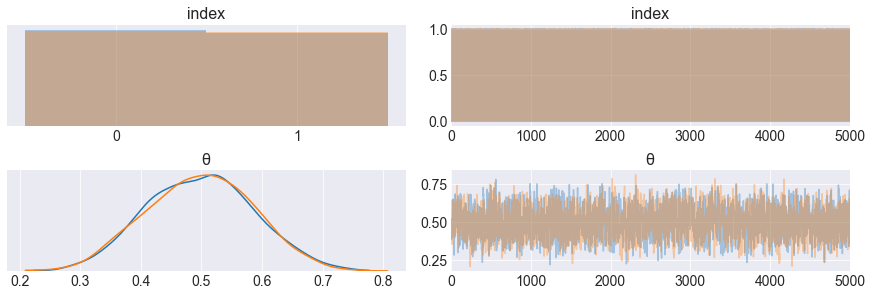

In [42]:
az.plot_trace(coin_flips_trace);

#### Stochastic model selection: Binomial model

In [44]:
with pm.Model() as head_count_model:
    p = np.array([0.5, 0.5])
    index = pm.Categorical('index', p=p)
    m = pm.math.switch(pm.math.eq(index, 0), priors[0], priors[1])
    θ = pm.Beta('θ', m[0], m[1])
    y = pm.Binomial('y', len(flips), θ, observed=sum(flips))
    head_count_trace = pm.sample(5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [index]
>NUTS: [θ]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:06<00:00, 1734.97draws/s]
The number of effective samples is smaller than 25% for some parameters.


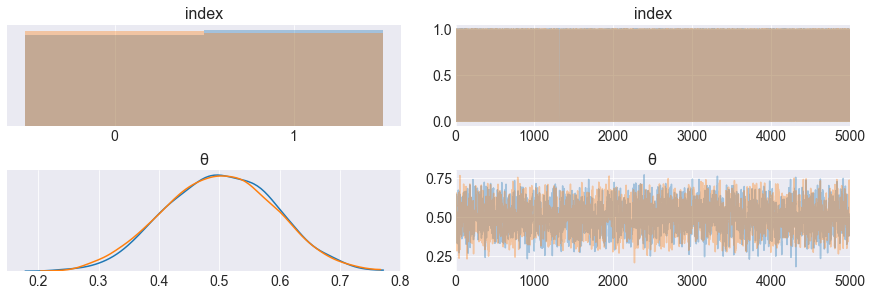

In [45]:
az.plot_trace(head_count_trace);

In [74]:
p1 = coin_flips_trace['index'].mean()
# The last factor is to avoid taking the prior on 'index' into account
bayes_factor = (1 - p1) / p1 * p[1] / p[0] 
print(bayes_factor)

10.890606420927469


### Obtain the marginal likelihood directly via sampling

Note that Bishop refers to this marginal likelihood as the *model evidence* (see page 161 of *Pattern recognition and machine learning*). In the context of Bayesian model selection the terms *marginal likelihood* and *model evidence* seem to be used interchangeably (e.g., here https://en.wikipedia.org/wiki/Marginal_likelihood).

In [60]:
traces_coin_flips = []
models_coin_flips = []
for (i, (α, β)) in enumerate(priors):
    with pm.Model() as model:
        θ = pm.Beta('θ', α, β)
        y = pm.Bernoulli('y', θ, observed=flips)
        traces_coin_flips.append(pm.sample(2500, step=pm.SMC()))
        models_coin_flips.append(model)

Sample initial stage: ...
Stage: 0 Beta: 0.709961 Steps: 25
100%|██████████| 2500/2500 [00:02<00:00, 891.03it/s]
Stage: 1 Beta: 1.000000 Steps: 4
100%|██████████| 2500/2500 [00:00<00:00, 4388.34it/s]
Sample initial stage: ...
Stage: 0 Beta: 0.785156 Steps: 25
100%|██████████| 2500/2500 [00:02<00:00, 872.96it/s]
Stage: 1 Beta: 1.000000 Steps: 4
100%|██████████| 2500/2500 [00:00<00:00, 5021.46it/s]


In [62]:
print(models_coin_flips[0].marginal_likelihood / models_coin_flips[1].marginal_likelihood)

0.9614579463784209
